## Convective Regime Analysis

Here, I analyse a simulation where I hacked the Isca code, so it output useful tendency information.

Some diagnostics are different for this simulation. All have units of *K/s*:
* `dt_vg_diffusion`: Total temperature tendency before any diffusion calculation (basically just `dt_tg_convection` + `tdt_rad`).
* `dt_ug_diffusion`: Total temperature tendency after downward diffusion, but before upward diffusion. This is very similar to the above tendency as downward diffusion does not have much effect.
* `dt_tg_diffusion`: Total temperature tendency after all diffusion calculations. This differs near the surface to the above.
* `ucomp`: Total temperature tendency after both horizontal and vertical advection and `four_in_one` function. Basically after `spectral_dynamics`.
* `vcomp`: Total temperature tendency after the leapfrog procedure. I.e. this is `(temp(future)-temp(current))/time_step`.
* `omega`: Vertical advection temperature tendency.

In addition, I changed `delta_t_surf` so units are *K/s* rather than *K*, for ease of comparison. But still gives temperature tendency of the surface.

Here I look at different convective regimes (non-convecting vs convecting days) and see how CAPE and temperature tendency varies with the convective timescale parameter.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-03-21 15:25:43,421 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [184]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
save_suffix = '.pdf'          # if for paper
# save_suffix = '.jpg'
dpi = {'.pdf': 800, '.jpg': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [322]:
var_keep = ['temp', 'sphum', 'height', 'cape', 'klzbs', 't_surf', 't_ref', 'dt_tg_convection', 'dt_tg_diffusion', 'tdt_rad', 'convflag']
exp_dir = 'play/temp_tendency/'
tau_lw_ref = 1
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}_taubm=2000", f"k={str(tau_lw_ref).replace('.','_')}", 
             f"k={str(tau_lw_ref).replace('.','_')}_taubm=72000"]
# exp_names = [f"k=3_5_no_diffusion", f"k={str(tau_lw_ref).replace('.','_')}", f"k=3_5_no_diffusion_taubm=2000"]
# exp_names = [f"k=3_5_taubm=2000", f"k=3_5"]
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []
conv_timescale = []

use_time_start = 360*2
# use_time_start = 0      # because little data
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf))]      # only keep after spin up
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        conv_timescale += [namelist['qe_moist_convection_nml']['tau_bm']]
    except KeyError:
        conv_timescale += [7200]        # default value
# conv_timescale = ['$\kappa=3.5$ no diffusion (7200)', '$\kappa=3.5$ (7200)', '$\kappa=3.5$ no diffusion (2000)']

In [323]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 500
lzb_thresh = 13         # Need LNB < 487hPa to be convecting i.e. so pressure_ft is in convecting area
convflag_thresh = 1     # Need convflag > 1 to be convecting (1 for shallow, 2 for deep and 0 for none) so on average is at least shallow.

region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40  # should be 40, but saving memory
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 80
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

# Chose whether to only consider summer days for mean or all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH 
if region == 'tropics':
    use_summer = False      # if true, will set ds will only contain summer months. Do this outside tropics
elif region == 'extratropics':
    use_summer = True

ds = {'all': [], 'conv': [], 'non-conv': []}  # need both all and summer day dataset
lat_use_ind = np.where((np.abs(ds_base[0].lat) <= lat_max) & (np.abs(ds_base[0].lat) >= lat_min))[0]
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i].sel(pfull=[np.inf, pressure_ft], method='nearest')
        ds_use = ds_use.isel(lat=lat_use_ind)
        if use_summer:
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)).load()
        ds['all'] += [ds_use]
        keep_conv = np.logical_and(ds_use.klzbs<=lzb_thresh, ds_use.convflag >= convflag_thresh)
        ds['conv'] += [ds_use.where(keep_conv)]
        ds['non-conv'] += [ds_use.where(np.invert(keep_conv))]
        pbar.update(1)
n_lat = ds['all'][0].lat.shape[0]
lat_weights = np.cos(np.deg2rad(ds['all'][0].lat))     # latitude area weighting is just the cosine
ind_surf = 0
ind_ft = 1
p_surface = float(ds['all'][0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds['all'][0].pfull[ind_ft] * 100)
n_pressure = 2

100%|██████████| 3/3 [00:44<00:00, 14.84s/it]


In [324]:
# Trying to replicate reference q profile in Isca
# from isca_tools.utils.moist_physics import mixing_ratio_from_partial_pressure, mixing_ratio_from_sphum
# from isca_tools.utils.constants import R, R_v
# def get_q_ref(q, rhbm=0.7, pressure=p_surface):
#     rp = mixing_ratio_from_sphum(q)
#     eref = rhbm * pressure * rp / (rp + (R/R_v))
#     rp = mixing_ratio_from_partial_pressure(eref, pressure)
#     return rp / (1+rp)

In [325]:
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

# Note the quant3_type doesn't make much difference and only really makes a difference in the tropics
# where the equivalence of the temperature and moist static energy percentiles is not as valid.
quant3_method = 'temp'            # Take percentile to be temperature percentile
# quant3_method = 'mse'             # Take percentile to be of near-surface mse
# quant3_method = 'sphum'             # Take percentile to be of near-surface sphum
# All quantiles are over all days
temp_quant3 = {key: np.zeros((n_exp, n_pressure, n_lat, n_quant)) for key in ds}
mse_quant3 = {key: np.zeros((n_exp, n_pressure, n_lat, n_quant)) for key in ds}   # one for each pressure, and another for ref mse
mse_quant3_ref = {key: np.zeros((n_exp, n_pressure, n_lat, n_quant)) for key in ds} 

klzb_quant3 = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds} 
convflag_quant3 = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds} 
cape_quant3 = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds} 

temp_tend_conv_quant3 = {key: np.zeros((n_exp, n_pressure, n_lat, n_quant)) for key in ds} 
temp_tend_rad_quant3 = {key: np.zeros((n_exp, n_pressure, n_lat, n_quant)) for key in ds} 
temp_tend_diffusion_quant3 = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds} 
temp_surf_diff_quant3 = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds} 
temp_convref_diff_quant3 = {key: np.zeros((n_exp, n_pressure, n_lat, n_quant)) for key in ds} 

sphum_quant3 = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds}        # specific humidity as a function of quant3_type quantile
z_quant3 = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds}        # specific humidity as a function of quant3_type quantile
fract_conv_days = np.zeros((n_exp, n_lat, n_quant))       # record fraction days at each that are quantile are convecting
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse = moist_static_energy(ds['all'][i].temp[ind_surf], ds['all'][i].sphum[ind_surf], ds['all'][i].height[ind_surf])
        mse_ft = moist_static_energy(ds['all'][i].temp[ind_ft], sphum_sat(ds['all'][i].temp[ind_ft], pressure_ft_actual), 
                                     ds['all'][i].height[ind_ft])
        mse_ref = moist_static_energy(ds['all'][i].t_ref[ind_surf], ds['all'][i].sphum[ind_surf], ds['all'][i].height[ind_surf])
        # mse_ref = moist_static_energy(ds['all'][i].t_ref[ind_surf], get_q_ref(ds['all'][i].sphum[ind_surf]), 
        #                               ds['all'][i].height[ind_surf])
        mse_ft_ref = moist_static_energy(ds['all'][i].t_ref[ind_ft], sphum_sat(ds['all'][i].t_ref[ind_ft], pressure_ft_actual),
                                         ds['all'][i].height[ind_ft])
        for k in range(n_lat):
            mse_use = [mse[k], mse_ft[k], mse_ref[k], mse_ft_ref[k]]
            for j, quant in enumerate(quant_plot):
                if quant3_method == 'temp':
                    use_ind = get_quant_ind(ds['all'][i].temp[ind_surf, k], quant, 0.5, 0.5)
                elif quant3_method == 'mse':
                    use_ind = get_quant_ind(mse[k], quant, 0.5, 0.5)
                elif quant3_method == 'sphum':
                    use_ind = get_quant_ind(ds['all'][i].sphum[ind_surf, k], quant, 0.5, 0.5)
                else:
                    raise ValueError('quant3_type not valid')
                klzb_quant3[i, k, j] = ds['all'][i].klzbs[k, use_ind].mean(dim='lon_time', skipna=True)                
                for key in ds:
                    keep = ds[key][i].temp[ind_surf, k]>0
                    temp_quant3[key][i, :, k, j] = ds[key][i].temp[:, k, use_ind].mean(dim='lon_time', skipna=True)
                    mse_quant3[key][i, ind_surf, k, j] = mse_use[0].where(keep)[use_ind].mean(dim='lon_time', skipna=True)    
                    mse_quant3[key][i, ind_ft, k, j] = mse_use[1].where(keep)[use_ind].mean(dim='lon_time', skipna=True)
                    mse_quant3_ref[key][i, ind_surf, k, j] = mse_use[2].where(keep)[use_ind].mean(dim='lon_time', skipna=True)
                    mse_quant3_ref[key][i, ind_ft, k, j] = mse_use[3].where(keep)[use_ind].mean(dim='lon_time', skipna=True)
                    
                    klzb_quant3[key][i, k, j] = ds[key][i].klzbs[k, use_ind].mean(dim='lon_time', skipna=True)
                    convflag_quant3[key][i, k, j] = ds[key][i].convflag[k, use_ind].mean(dim='lon_time', skipna=True)
                    cape_quant3[key][i, k, j] = ds[key][i].cape[k, use_ind].mean(dim='lon_time', skipna=True)
                    
                    temp_tend_conv_quant3[key][i, :, k, j] = ds[key][i].dt_tg_convection[:, k, use_ind].mean(dim='lon_time', skipna=True)
                    temp_tend_rad_quant3[key][i, :, k, j] = ds[key][i].tdt_rad[:, k, use_ind].mean(dim='lon_time', skipna=True)
                    temp_tend_diffusion_quant3[key][i, k, j] = (ds[key][i].dt_tg_diffusion - ds[key][i].dt_tg_convection - 
                                                                ds[key][i].tdt_rad)[ind_surf, k, use_ind].mean(dim='lon_time', skipna=True)
                    temp_surf_diff_quant3[key][i, k, j] = (
                            ds[key][i].t_surf - ds[key][i].temp.isel(pfull=ind_surf))[k, use_ind].mean(dim='lon_time', skipna=True)
                    temp_convref_diff_quant3[key][i, :, k, j] = (
                            ds[key][i].t_ref - ds[key][i].temp)[:, k, use_ind].mean(dim='lon_time', skipna=True)
                    
                    sphum_quant3[key][i, k, j] = ds[key][i].sphum[ind_surf, k, use_ind].mean(dim='lon_time', skipna=True)
                    z_quant3[key][i, k, j] = ds[key][i].height[ind_ft, k, use_ind].mean(dim='lon_time', skipna=True)
                    
                    if key == 'conv':
                        fract_conv_days[i, k, j] = np.sum(keep[use_ind])/(keep[use_ind]).size
                pbar.update(1)

100%|██████████| 4158/4158 [04:00<00:00, 17.27it/s]


In [326]:
from isca_tools.utils.moist_physics import mixing_ratio_from_partial_pressure, mixing_ratio_from_sphum
from isca_tools.utils.constants import R, R_v
def get_q_ref(q, rhbm=0.7, pressure=p_surface):
    rp = mixing_ratio_from_sphum(q)
    eref = rhbm * pressure * rp / (rp + (R/R_v))
    rp = mixing_ratio_from_partial_pressure(eref, pressure)
    return rp / (1+rp)

In [327]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds_base[0].pfull)), ds_base[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

### Convective Details
Plot `convflag` (whether deep or shallow convection), level of neutral buoyancy and CAPE as a function of quantile for each simulation to see how convection varies with temperature.

In [328]:
x_var = [quant_plot for i in range(n_exp)]
x_var_name = 'Temperature percentile, $x$' if quant3_method == 'temp' else 'MSE percentile, $x$'
x_lim = [0, 100]
# x_var = [np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights) for i in range(n_exp)]
# x_var_name = 'Near-surface temperature [K]'
# x_lim = [np.asarray(x_var).min(), np.asarray(x_var).max()]

Text(0, 0.5, 'Percentage of days convecting [%]')

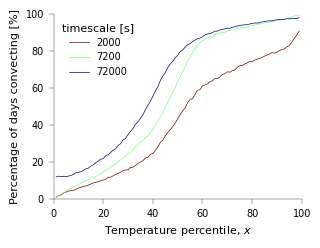

In [329]:
colors_exp = plt.cm.jet(np.linspace(0,1,n_exp))[::-1]
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(x_var[i], 100*np.average(fract_conv_days[i], axis=0, weights=lat_weights), color=colors_exp[i], label=conv_timescale[i])
ax.set_xlim(x_lim)
ax.set_ylim(0, 100)
ax.legend(title='timescale [s]')
ax.set_xlabel(x_var_name)
ax.set_ylabel('Percentage of days convecting [%]')

In [330]:
use_x_thresh = 0.2      # Only plot quantiles where more than this fraction of days convecting or not
use_x = {'conv': np.asarray([np.average(fract_conv_days[i], axis=0, weights=lat_weights)>use_x_thresh for i in range(n_exp)]), 
         'non-conv': np.asarray([(1-np.average(fract_conv_days[i], axis=0, weights=lat_weights))>use_x_thresh for i in range(n_exp)])}
use_x['all'] = np.full_like(use_x['conv'], True)
linestyles_conv = {'all': '-', 'conv': '--', 'non-conv': ':'}

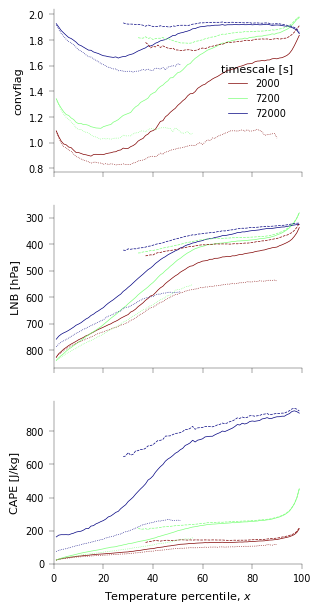

In [344]:
save_convflag_fig = True
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 3*width['one_col']/ar), sharex=True)
for key in ds:
    for i in range(n_exp):
        use = use_x[key][i]
        ax[0].plot(x_var[i][use], np.average(convflag_quant3[key][i], axis=0, weights=lat_weights)[use],
                   color=colors_exp[i], linestyle=linestyles_conv[key], label=conv_timescale[i] if key=='all' else None)
        ax[1].plot(x_var[i][use], lzb(np.average(klzb_quant3[key][i], axis=0, weights=lat_weights))[use],
                color=colors_exp[i], linestyle=linestyles_conv[key])
        ax[2].plot(x_var[i][use], np.average(cape_quant3[key][i], axis=0, weights=lat_weights)[use],
                   color=colors_exp[i], linestyle=linestyles_conv[key])
ax[1].invert_yaxis()
ax[-1].set_xlabel(x_var_name)
ax[0].set_ylabel('convflag')
ax[1].set_ylabel('LNB [hPa]')
ax[2].set_ylabel('CAPE [J/kg]')
ax[0].legend(title='timescale [s]')
ax[0].set_xlim(x_lim)
ax[2].set_ylim(0, ax[2].get_ylim()[1])

if save_fig or save_convflag_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convflag_{region}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Temperature Tendencies
Plot the different contributions to the temperature tendency at the surface and free troposphere.

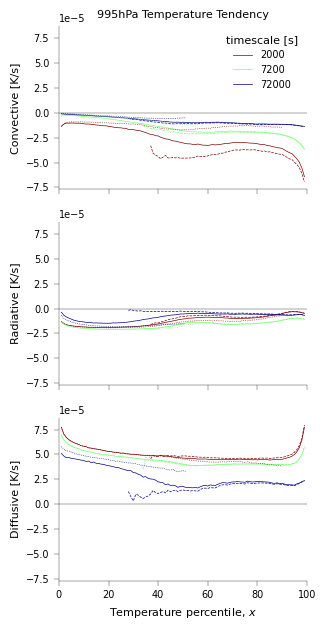

In [332]:
save_temp_tend_surf_fig = False
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 3*width['one_col']/ar), sharex=True, sharey=True)
for key in ds:
    for i in range(n_exp):
        use = use_x[key][i]
        ax[0].plot(x_var[i][use], np.average(temp_tend_conv_quant3[key][i, ind_surf], axis=0, weights=lat_weights)[use],
                   color=colors_exp[i], linestyle=linestyles_conv[key], label=conv_timescale[i] if key=='all' else None)
        ax[1].plot(x_var[i][use], np.average(temp_tend_rad_quant3[key][i, ind_surf], axis=0, weights=lat_weights)[use],
                color=colors_exp[i], linestyle=linestyles_conv[key])
        ax[2].plot(x_var[i][use], np.average(temp_tend_diffusion_quant3[key][i], axis=0, weights=lat_weights)[use],
                   color=colors_exp[i], linestyle=linestyles_conv[key])
ax[-1].set_xlabel(x_var_name)
ax[0].set_ylabel('Convective [K/s]')
ax[1].set_ylabel('Radiative [K/s]')
ax[2].set_ylabel('Diffusive [K/s]')
ax[0].legend(title='timescale [s]')
ax[0].set_xlim(x_lim)
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_title(f'{round(p_surface/100)}hPa Temperature Tendency')
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(-5,-5))
if save_fig or save_temp_tend_surf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_tend_surf_{region}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

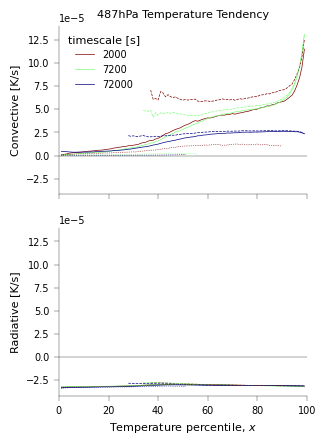

In [333]:
save_temp_tend_ft_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True, sharey=True)
for key in ds:
    for i in range(n_exp):
        use = use_x[key][i]
        ax[0].plot(x_var[i][use], np.average(temp_tend_conv_quant3[key][i, ind_ft], axis=0, weights=lat_weights)[use],
                   color=colors_exp[i], linestyle=linestyles_conv[key], label=conv_timescale[i] if key=='all' else None)
        ax[1].plot(x_var[i][use], np.average(temp_tend_rad_quant3[key][i, ind_ft], axis=0, weights=lat_weights)[use],
                color=colors_exp[i], linestyle=linestyles_conv[key])
ax[-1].set_xlabel(x_var_name)
ax[0].set_ylabel('Convective [K/s]')
ax[1].set_ylabel('Radiative [K/s]')
ax[0].legend(title='timescale [s]')
ax[0].set_xlim(x_lim)
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_title(f'{round(pressure_ft_actual/100)}hPa Temperature Tendency')
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(-5,-5))
if save_fig or save_temp_tend_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_tend_ft_{region}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### MSE Difference
See how MSE differs between surface and free troposphere as function of near-surface temperature percentile. Would expect them to be equal if convection is setting temperature profile.

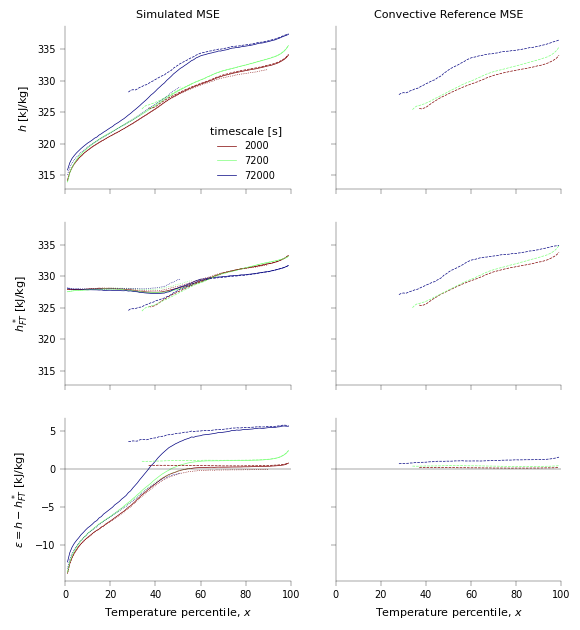

In [334]:
save_mse_fig = True
fig, ax = plt.subplots(3,2, figsize=(2*width['one_col'], 3*width['one_col']/ar), sharex=True, sharey='row')
ax[0, 0].sharey(ax[1, 0])
for key in ds:
    for i in range(n_exp):
        use = use_x[key][i]
        for j, mse_use in enumerate([mse_quant3, mse_quant3_ref]):
            if j==1 and key != 'conv':
                continue
            ax[0, j].plot(x_var[i][use], np.average(mse_use[key][i, ind_surf], axis=0, weights=lat_weights)[use],
                       color=colors_exp[i], linestyle=linestyles_conv[key], label=conv_timescale[i] if key=='all' else None)
            ax[1, j].plot(x_var[i][use], np.average(mse_use[key][i, ind_ft], axis=0, weights=lat_weights)[use],
                    color=colors_exp[i], linestyle=linestyles_conv[key])
            ax[2, j].plot(x_var[i][use], np.average(mse_use[key][i, ind_surf] - mse_use[key][i, ind_ft], axis=0, 
                                                    weights=lat_weights)[use],
                          color=colors_exp[i], linestyle=linestyles_conv[key])
for i, j in enumerate(['Simulated MSE', 'Convective Reference MSE']):
    ax[-1, i].set_xlabel(x_var_name)
    ax[2, i].axhline(0, color='k', lw=ax_linewidth)
    ax[0, i].set_title(j)
ax[0, 0].set_ylabel('$h$ [kJ/kg]')
ax[1, 0].set_ylabel('$h^*_{FT}$ [kJ/kg]')
ax[2, 0].set_ylabel('$\epsilon = h - h^*_{FT}$ [kJ/kg]')
ax[0, 0].legend(title='timescale [s]')
ax[0, 0].set_xlim(x_lim)
if save_fig or save_mse_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_sim_vs_convref_{region}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

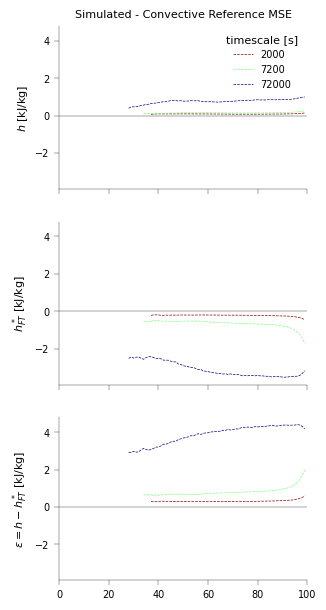

In [335]:
save_mse_convref_fig = True
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 3*width['one_col']/ar), sharex=True, sharey=True)
for key in ['conv']:
    for i in range(n_exp):
        use = use_x[key][i]
        ax[0].plot(x_var[i][use], np.average(mse_quant3[key][i, ind_surf] - mse_quant3_ref[key][i, ind_surf], 
                                             axis=0, weights=lat_weights)[use],
                   color=colors_exp[i], linestyle=linestyles_conv[key], label=conv_timescale[i])
        ax[1].plot(x_var[i][use], np.average(mse_quant3[key][i, ind_ft] - mse_quant3_ref[key][i, ind_ft], 
                                             axis=0, weights=lat_weights)[use],
                   color=colors_exp[i], linestyle=linestyles_conv[key], label=conv_timescale[i])
        ax[2].plot(x_var[i][use], np.average(mse_quant3[key][i, ind_surf] - mse_quant3[key][i, ind_ft] - 
                                             (mse_quant3_ref[key][i, ind_surf] - mse_quant3_ref[key][i, ind_ft]), axis=0, 
                                                weights=lat_weights)[use],
                      color=colors_exp[i], linestyle=linestyles_conv[key])
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$h$ [kJ/kg]')
ax[1].set_ylabel('$h^*_{FT}$ [kJ/kg]')
ax[2].set_ylabel('$\epsilon = h - h^*_{FT}$ [kJ/kg]')
ax[0].legend(title='timescale [s]')
ax[0].set_xlim(x_lim)
ax[0].set_title('Simulated - Convective Reference MSE')
if save_fig or save_mse_convref_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_sim_minus_convref_{region}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

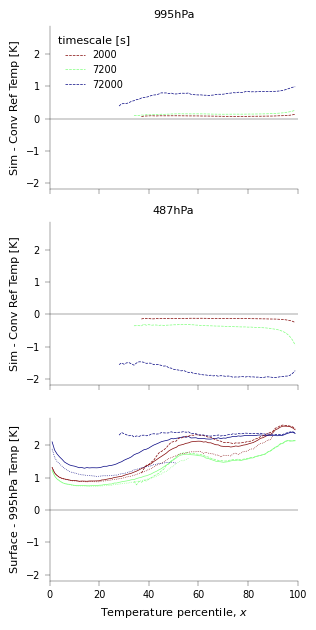

In [336]:
save_temp_diff_fig = False
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 3*width['one_col']/ar), sharex=True, sharey=True)
for key in ds:
    for i in range(n_exp):
        use = use_x[key][i]
        ax[2].plot(x_var[i][use], np.average(temp_surf_diff_quant3[key][i], axis=0, weights=lat_weights)[use],
                   color=colors_exp[i], linestyle=linestyles_conv[key])
        if key != 'conv':
            continue
        ax[0].plot(x_var[i][use], -np.average(temp_convref_diff_quant3[key][i, ind_surf], axis=0, weights=lat_weights)[use],
                color=colors_exp[i], linestyle=linestyles_conv[key], label=conv_timescale[i])
        ax[1].plot(x_var[i][use], -np.average(temp_convref_diff_quant3[key][i, ind_ft], axis=0, weights=lat_weights)[use],
                   color=colors_exp[i], linestyle=linestyles_conv[key])
ax[-1].set_xlabel(x_var_name)
ax[1].set_ylabel('Radiative [K/s]')
ax[2].set_ylabel('Diffusive [K/s]')
ax[0].legend(title='timescale [s]')
ax[0].set_xlim(x_lim)
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_title(f'{round(p_surface/100)}hPa')
ax[0].set_ylabel('Sim - Conv Ref Temp [K]')
ax[1].set_title(f'{round(pressure_ft_actual/100)}hPa')
ax[1].set_ylabel('Sim - Conv Ref Temp [K]')
ax[2].set_ylabel(f'Surface - {round(p_surface/100)}hPa Temp [K]')

if save_fig or save_temp_diff_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_diff_{region}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)